# Computation Biology Summer Program Hackathon

This [Jupyter notebook](https://jupyter.org/) gives examples on how to use the various [REST](https://en.wikipedia.org/wiki/Representational_state_transfer) web services from the [Knowledge Systems Group](https://www.mskcc.org/research-areas/labs/nikolaus-schultz). In this hackathon we will pull data from those APIs to make visualizations.

## How to run the notebook

This notebook can be executed on your own machine after installing Jupyter. Please install the Python 3 version of anaconda: https://www.anaconda.com/download/. After having that set up you can install Jupyter with:

```bash
conda install jupyter

```

For these examples we also require the [Swagger API](https://swagger.io/specification/) client `bravado`.

```bash
conda install -c conda-forge bravado
```

And the popular data analysis libraries pandas, matplotlib and seaborn:

```
conda install pandas matplotlib seaborn
```

Then clone this repo:

```
git clone https://github.com/mskcc/cbsp-hackathon
```

And run Jupyter in this folder
```
cd cbsp-hackathon/0-introduction
jupyter
```
That should open Jupyter in a new browser window and you should be able to open this notebook using the web interface. You can then follow along with the next steps.

## How to use the notebook

The notebook consists of cells which can be executed by clicking on one and pressing shift+f. In the toolbar at the top there is a dropdown which indicates what type of cell you have selected e.g. `Code` or [Markdown](https://en.wikipedia.org/wiki/Markdown). The former will be executed as raw Python code the latter is a markup language and will be run through a Markdown parser. Both generate HTML that will be printed directly to the notebook page.

There a few keyboard shortcuts that are good to know. That is: `b` creates a new cell below the one you've selected and `a` above the one you selected. Editing a cell can be done with a single click for a code cell and a double click for a Markdown cell. A complete list of all keyboard shortcuts can be found by pressing the keyboard icon in the toolbar at the top.

 Give it a shot by editing one of the cells and pressing shift+f.

## Using the REST APIs

All [REST](https://en.wikipedia.org/wiki/Representational_state_transfer) web services from the [Knowledge Systems Group](https://www.mskcc.org/research-areas/labs/nikolaus-schultz) we will be using in this tutorial have their REST APIs defined following the [Open API / Swagger specification](https://swagger.io/specification/). This allows us to use `bravado` to connect to them directly, and explore the API interactively.

For example this is how to connect to the [cBioPortal](https://www.cbioportal.org) API:

In [1]:
from bravado.client import SwaggerClient

cbioportal = SwaggerClient.from_url('https://www.cbioportal.org/api/v2/api-docs',
                                config={"validate_requests":False,"validate_responses":False,"validate_swagger_spec":False})
print(cbioportal)

SwaggerClient(https://www.cbioportal.org/api)


You can now explore the API by using code completion, press `Tab` after typing `cbioportal.`:

In [ ]:
cbioportal.

This will give a dropdown with all the different APIs, similar to how you can see them here on the cBioPortal website: https://www.cbioportal.org/api/swagger-ui/index.html.

You can get the name of an endpoint by going to that website and clicking on any of the endpoints. The URL will then update to show the name of the endpoint. For example, the endpoint for getting a cancer type is `getCancerTypesUsingGET`, which shows up on the website as https://www.cbioportal.org/api/swagger-ui/index.html#/Cancer%20Types/getCancerTypeUsingGET.

The documentation shows one of the parameters is `cancerTypeId` of type `string`, the example `acc` is mentioned:

In [5]:
acc = cbioportal.Cancer_Types.getCancerTypeUsingGET(cancerTypeId='acc').result()
print(acc)

TypeOfCancer(cancerTypeId='acc', dedicatedColor='Purple', name='Adrenocortical Carcinoma', parent='adrenal_gland', shortName='ACC')


You can see that the JSON output returned by the cBioPortal API gets automatically converted into an object called `TypeOfCancer`. This object can be explored interactively after typing `acc.`:

In [ ]:
acc.

### cBioPortal API

[cBioPortal](https://www.cbioportal.org) stores cancer genomics data from a large number of published studies. Let's figure out:

- how many studies are there?
- how many cancer types do they span?
- how many samples in total?
- which study has the largest number of samples?

In [6]:
studies = cbioportal.Studies.getAllStudiesUsingGET().result()
cancer_types = cbioportal.Cancer_Types.getAllCancerTypesUsingGET().result()

print("In total there are {} studies in cBioPortal, spanning {} different types of cancer.".format(
    len(studies),
    len(cancer_types)
))

In total there are 411 studies in cBioPortal, spanning 885 different types of cancer.


To get the total number of samples in each study we have to look a bit more at the response of the studies endpoint:

In [7]:
dir(studies[0])

['allSampleCount',
 'cancerType',
 'cancerTypeId',
 'citation',
 'cnaSampleCount',
 'completeSampleCount',
 'description',
 'groups',
 'importDate',
 'massSpectrometrySampleCount',
 'methylationHm27SampleCount',
 'miRnaSampleCount',
 'mrnaMicroarraySampleCount',
 'mrnaRnaSeqSampleCount',
 'mrnaRnaSeqV2SampleCount',
 'name',
 'pmid',
 'publicStudy',
 'readPermission',
 'referenceGenome',
 'rppaSampleCount',
 'sequencedSampleCount',
 'status',
 'studyId',
 'treatmentCount']

We can sum the `allSampleCount` values of each study in cBioPortal:

In [10]:
print("The total number of samples in all studies is: {}".format(sum([x.allSampleCount for x in studies])))

The total number of samples in all studies is: 264449


Let's see which study has the largest number of samples:

In [11]:
sorted_studies = sorted(studies, key=lambda x: x.allSampleCount)
sorted_studies[-1]

CancerStudy(allSampleCount=47530, cancerType=None, cancerTypeId='mixed', citation='Stonestrom et al. Blood Adv 2023', cnaSampleCount=None, completeSampleCount=None, description='Clonal hematopoiesis mutations identified in blood samples from 47,532 patients whose tumor-blood pairs were analyzed using MSK-IMPACT.', groups='', importDate='2023-12-21 13:11:31', massSpectrometrySampleCount=None, methylationHm27SampleCount=None, miRnaSampleCount=None, mrnaMicroarraySampleCount=None, mrnaRnaSeqSampleCount=None, mrnaRnaSeqV2SampleCount=None, name='Cancer Therapy and Clonal Hematopoiesis (MSK, Blood Adv 2023)', pmid=None, publicStudy=True, readPermission=True, referenceGenome='hg19', rppaSampleCount=None, sequencedSampleCount=None, status=0, studyId='msk_ch_2023', treatmentCount=None)

Now that we've answered the inital questions we can dig a little deeper into this specific study:

- How many patients are in this study?
- What gene is most commonly mutated across the different samples?
- Does this study span one or more types of cancer?

The description of the study with id `msk_impact_2017` study mentions there are 10,000 patients sequenced. Can we find this data in the cBioPortal?

In [12]:
patients = cbioportal.Patients.getAllPatientsInStudyUsingGET(studyId='msk_impact_2017').result()
print("The msk_impact_2017 study spans {} patients".format(len(patients)))

The msk_impact_2017 study spans 10336 patients


Now let's try to figure out what gene is most commonly mutated. For this we can check the endpoints in the group `K_Mutations`. When looking at these endpoints it seems that a study can have multiple molecular profiles. This is because samples might have been sequenced using different assays (e.g. targeting a subset of genes or all genes). An example for the `acc_tcga` study is given for a molecular profile (`acc_tcga_mutations`) and a collection of samples (`msk_impact_2017_all`). We can use the same approach for the `msk_impact_2017` study. This will take a few seconds.  You can use the command `%%time` to time a cell):

In [13]:
%%time

mutations = cbioportal.Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET(
    molecularProfileId='msk_impact_2017_mutations',
    sampleListId='msk_impact_2017_all'
).result()

CPU times: user 1.07 s, sys: 51 ms, total: 1.12 s
Wall time: 4.81 s


We can explore what the mutation data structure looks like:

In [14]:
mutations[0]

Mutation(alleleSpecificCopyNumber=None, aminoAcidChange=None, center='NA', chr='9', driverFilter=None, driverFilterAnnotation=None, driverTiersFilter=None, driverTiersFilterAnnotation=None, endPosition=133760514, entrezGeneId=25, gene=None, keyword='ABL1 truncating', molecularProfileId='msk_impact_2017_mutations', mutationStatus='NA', mutationType='Frame_Shift_Del', namespaceColumns=None, ncbiBuild='GRCh37', normalAltCount=None, normalRefCount=None, patientId='P-0000507', proteinChange='K947Sfs*122', proteinPosEnd=947, proteinPosStart=946, referenceAllele='C', refseqMrnaId='NM_005157.4', sampleId='P-0000507-T01-IM3', startPosition=133760514, studyId='msk_impact_2017', tumorAltCount=80, tumorRefCount=759, uniquePatientKey='UC0wMDAwNTA3Om1za19pbXBhY3RfMjAxNw', uniqueSampleKey='UC0wMDAwNTA3LVQwMS1JTTM6bXNrX2ltcGFjdF8yMDE3', validationStatus='NA', variantAllele='-', variantType='DEL')

It seems that the `gene` field is not filled in. To keep the response size of the API small, the API uses a parameter called `projection` that indicates whether or not to return all fields of an object or only a portion of the fields. By default it will use the `SUMMARY` projection. But because in this case we want to `gene` information, we'll use the `DETAILED` projection instead, so let's update the previous statement:

In [15]:
%%time 

mutations = cbioportal.Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET(
    molecularProfileId='msk_impact_2017_mutations',
    sampleListId='msk_impact_2017_all',
    projection='DETAILED'
).result()

CPU times: user 1.55 s, sys: 91.4 ms, total: 1.64 s
Wall time: 6.05 s


You can see the response time is slightly slower. Let's check if the gene field is filled in now:

In [16]:
mutations[0]

Mutation(alleleSpecificCopyNumber=None, aminoAcidChange=None, center='NA', chr='9', driverFilter=None, driverFilterAnnotation=None, driverTiersFilter=None, driverTiersFilterAnnotation=None, endPosition=133760514, entrezGeneId=25, gene=Gene(entrezGeneId=25, geneticEntityId=None, hugoGeneSymbol='ABL1', type='protein-coding'), keyword='ABL1 truncating', molecularProfileId='msk_impact_2017_mutations', mutationStatus='NA', mutationType='Frame_Shift_Del', namespaceColumns=None, ncbiBuild='GRCh37', normalAltCount=None, normalRefCount=None, patientId='P-0000507', proteinChange='K947Sfs*122', proteinPosEnd=947, proteinPosStart=946, referenceAllele='C', refseqMrnaId='NM_005157.4', sampleId='P-0000507-T01-IM3', startPosition=133760514, studyId='msk_impact_2017', tumorAltCount=80, tumorRefCount=759, uniquePatientKey='UC0wMDAwNTA3Om1za19pbXBhY3RfMjAxNw', uniqueSampleKey='UC0wMDAwNTA3LVQwMS1JTTM6bXNrX2ltcGFjdF8yMDE3', validationStatus='NA', variantAllele='-', variantType='DEL')

Now that we have the gene field we can check what gene is most commonly mutated: 

In [17]:
from collections import Counter
mutation_counts = Counter([m.gene.hugoGeneSymbol for m in mutations])
mutation_counts.most_common(5)

[('TP53', 4954),
 ('APC', 1674),
 ('KRAS', 1670),
 ('TERT', 1549),
 ('PIK3CA', 1517)]

We can verify that these results are correct by looking at the study view of the MSK-IMPACT study on the cBioPortal website: https://www.cbioportal.org/study/summary?id=msk_impact_2017. Note that the website uses the REST API we've been using in this hackathon, so we would expect those numbers to be the same, but good to do a sanity check. We see that the number of patients is indeed 10,336. But the number of samples with a mutation in TP53 is 4,561 instead of 4,985. Can you spot why they differ?

Next question:

- How many samples have a TP53 mutation?

For this exercise it might be useful to use a [pandas dataframe](https://pandas.pydata.org/) to be able to do grouping operations. You can convert the mutations result to a dataframe like this:

In [18]:
import pandas as pd

mdf = pd.DataFrame.from_dict([
    # python magic that combines two dictionaries:
    dict(
        {k:getattr(m,k) for k in dir(m)},
        **{k:getattr(m.gene,k) for k in dir(m.gene)}) 
    # create one item in the list for each mutation
    for m in mutations
])

The DataFrame is a data type originally from `Matlab` and `R` that makes it easier to work with columnar data. Pandas brings that data type to Python. There are also several performance optimizations by it using the data types from [numpy](https://www.numpy.org/).

Now that you have the data in a Dataframe you can group the mutations by the gene name and count the number of unique samples in TP53:

In [19]:
sample_count_per_gene = mdf.groupby('hugoGeneSymbol')['uniqueSampleKey'].nunique()

print("There are {} samples with a mutation in TP53".format(
    sample_count_per_gene['TP53']
))

There are 4538 samples with a mutation in TP53


It would be nice to visualize this result in context of the other genes by plotting the top 10 most mutated genes. For this you can use the matplotlib interface that integrates with pandas.

First  inline plotting in the notebook:

In [21]:
%matplotlib inline

<Axes: xlabel='hugoGeneSymbol'>

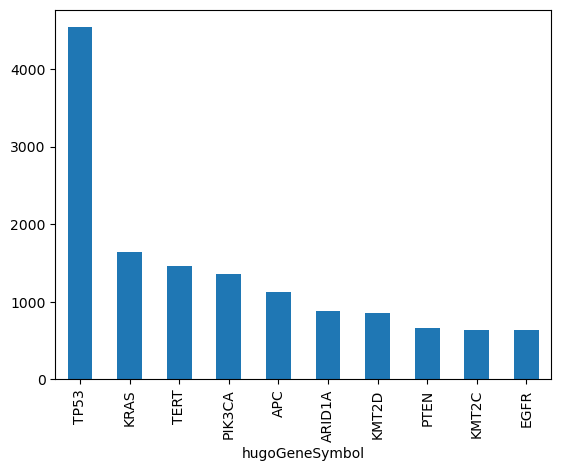

In [22]:
sample_count_per_gene.sort_values(ascending=False).head(10).plot(kind='bar')

Make it look a little nicer by importing seaborn:

In [24]:
import seaborn as sns
sns.set_style("white")
sns.set_context('notebook')

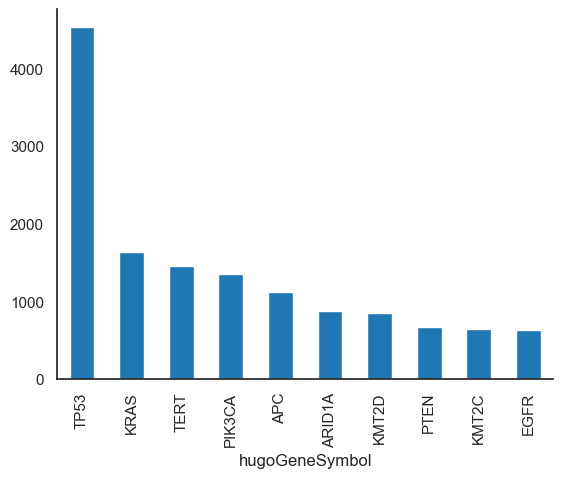

In [25]:
sample_count_per_gene.sort_values(ascending=False).head(10).plot(kind='bar')
sns.despine(trim=False)

You can further change the plot a bit by using the arguments to the plot function or using the matplotlib interface directly:

Text(0.5, 1.0, 'Number of mutations in genes in MSK-IMPACT (2017)')

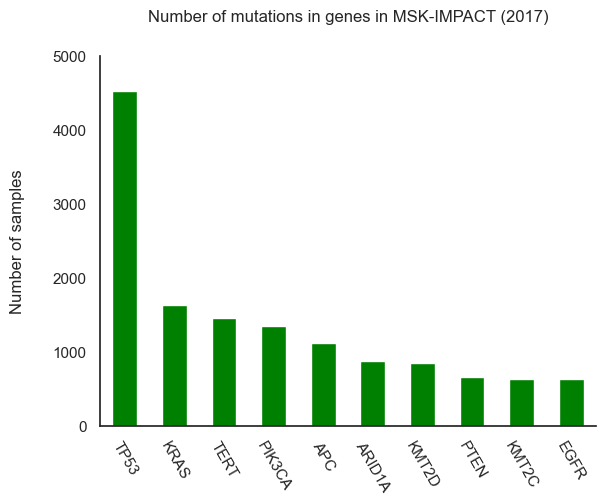

In [26]:
import matplotlib.pyplot as plt

sample_count_per_gene.sort_values(ascending=False).head(10).plot(
    kind='bar',
    ylim=[0,5000],
    color='green'
)
sns.despine(trim=False)
plt.xlabel('')
plt.xticks(rotation=300)
plt.ylabel('Number of samples',labelpad=20)
plt.title('Number of mutations in genes in MSK-IMPACT (2017)',pad=25)

A further extension of this plot could be to color the bar chart by the type of mutation in that sample (`mdf.mutationType`) and to include copy number alterations (see `Discrete Copy Number Alterations` endpoints).

### Genome Nexus API

[Genome Nexus](https://www.genomenexus.org) is a web service that aggregates all cancer related information about a particular mutation. Similarly to cBioPortal it provides a REST API following the [Swagger / OpenAPI specification](https://swagger.io/specification/).

In [27]:
from bravado.client import SwaggerClient

gn = SwaggerClient.from_url('https://www.genomenexus.org/v2/api-docs',
                            config={"validate_requests":False,
                                    "validate_responses":False,
                                    "validate_swagger_spec":False})
print(gn)

SwaggerClient(https://www.genomenexus.org/)


To look up annotations for a single variant, one can use the following endpoint:

In [28]:
variant = gn.annotation_controller.fetchVariantAnnotationByGenomicLocationGET(
    genomicLocation='7,140453136,140453136,A,T',
    # adds extra annotation resources, not included in default response:
    fields='hotspots annotation_summary'.split()
).result()

You can see a lot of information is provided for that particular variant if you type tab after `variant.`:

In [ ]:
variant.

For this example we will focus on the hotspot annotation and ignore the others. [Cancer hotspots](https://www.cancerhotspots.org/) is a popular web resource  which indicates whether particular variants have been found to be recurrently mutated in large scale cancer genomics data.

The example variant above is a hotspot:

In [28]:
variant.hotspots

HotspotAnnotation(annotation=[[Hotspot(hugoSymbol='BRAF', inframeCount=0, missenseCount=897, residue='V600', spliceCount=0, transcriptId='ENST00000288602', truncatingCount=0, tumorCount=897, type='single residue'), Hotspot(hugoSymbol='BRAF', inframeCount=None, missenseCount=None, residue='V600', spliceCount=None, transcriptId='ENST00000288602', truncatingCount=None, tumorCount=545, type='3d')], [], [], []], license='https://opendatacommons.org/licenses/odbl/1.0/')

Let's see how many hotspot mutations there are in the Cholangiocarcinoma (TCGA, PanCancer Atlas) study with study id `chol_tcga_pan_can_atlas_2018` from the cBioPortal:

In [29]:
%%time

cbioportal = SwaggerClient.from_url('https://www.cbioportal.org/api/v2/api-docs',
                                config={"validate_requests":False,
                                        "validate_responses":False,
                                        "validate_swagger_spec":False})

mutations = cbioportal.Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET(
    molecularProfileId='chol_tcga_pan_can_atlas_2018_mutations',
    sampleListId='chol_tcga_pan_can_atlas_2018_all',
    projection='DETAILED'
).result()

HTTPNotFound: 404 

Convert the results to a dataframe again:

In [30]:
import pandas as pd

mdf = pd.DataFrame.from_dict([
    # python magic that combines two dictionaries:
    dict(
        {k:getattr(m,k) for k in dir(m)},
        **{k:getattr(m.gene,k) for k in dir(m.gene)}) 
    # create one item in the list for each mutation
    for m in mutations
])

Then get only the unique mutations, to avoid calling the web service with the same variants:

In [33]:
variants = mdf['chr startPosition endPosition referenceAllele variantAllele'.split()]\
    .drop_duplicates()\
    .dropna(how='any',axis=0)\
    .reset_index()

Convert them to input that genome nexus will understand:

In [35]:
variants = variants.rename(columns={'chr':'chromosome','startPosition':'start','endPosition':'end'})\
    .to_dict(orient='records')
# remove the index field
for v in variants:
    del v['index']

In [36]:
print("There are {} mutations left to annotate".format(len(variants)))

There are 1958 mutations left to annotate


Annotate them with genome nexus:

In [37]:
%%time 

variants_annotated = gn.annotation_controller.fetchVariantAnnotationByGenomicLocationPOST(
    genomicLocations=variants,
    fields='hotspots annotation_summary'.split()
).result()

CPU times: user 670 ms, sys: 43 ms, total: 713 ms
Wall time: 15 s


Index the variants to make it easier to query them:

In [40]:
gn_dict = {
    "{},{},{},{},{}".format(
        v.annotation_summary.genomicLocation.chromosome,
        v.annotation_summary.genomicLocation.start,
        v.annotation_summary.genomicLocation.end,
        v.annotation_summary.genomicLocation.referenceAllele,
        v.annotation_summary.genomicLocation.variantAllele)
        :
        v for v in variants_annotated
}

Add a new column to indicate whether something is a hotspot

In [45]:
def is_hotspot(x):
    """TODO: Current structure for hotspots in Genome Nexus is a little funky.
    Need to check whether all lists in the annotation field are empty."""
    if x:
        return sum([len(a) for a in x.hotspots.annotation]) > 0
    else:
        return False

def create_dict_query_key(x):
    return "{},{},{},{},{}".format(
        x.chr, x.startPosition, x.endPosition, x.referenceAllele, x.variantAllele
    )

In [46]:
mdf['is_hotspot'] = mdf.apply(lambda x: is_hotspot(gn_dict.get(create_dict_query_key(x), None)), axis=1)

Then plot the results:

In [47]:
%matplotlib inline
import seaborn as sns
sns.set_style("white")
sns.set_context('notebook')
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Hotspots in Cholangiocarcinoma (TCGA, PanCancer Atlas)')

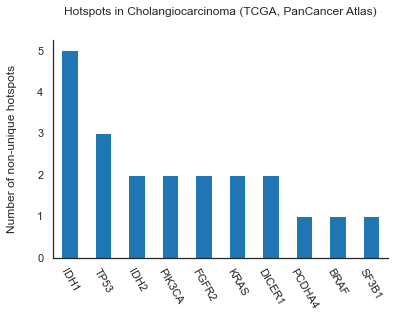

In [48]:
mdf.groupby('hugoGeneSymbol').is_hotspot.sum().sort_values(ascending=False).head(10).plot(kind='bar')

sns.despine(trim=False)
plt.xlabel('')
plt.xticks(rotation=300)
plt.ylabel('Number of non-unique hotspots',labelpad=20)
plt.title('Hotspots in Cholangiocarcinoma (TCGA, PanCancer Atlas)',pad=25)

### OncoKB API

[OncoKB](https://oncokb.org) is is a precision oncology knowledge base and contains information about the effects and treatment implications of specific cancer gene alterations. Similarly to cBioPortal and Genome Nexus it provides a REST API following the [Swagger / OpenAPI specification](https://swagger.io/specification/).

In [2]:
oncokb = SwaggerClient.from_url('https://www.oncokb.org/api/v1/v2/api-docs?group=Public%20APIs',
                            config={"validate_requests":False,
                                    "validate_responses":False,
                                    "validate_swagger_spec":False})
print(oncokb)

SwaggerClient(https://www.oncokb.org/api/v1)


To look up annotations for a variant, one can use the following endpoint:

In [3]:
variant = oncokb.Annotations.
    genomicLocation='7,140453136,140453136,A,T',
).result()

HTTPUnauthorized: 401 Unauthorized: Response specification matching http status_code 401 not found for operation Operation(annotateMutationsByGenomicChangeGetUsingGET_1). Either add a response specification for the status_code or use a `default` response.

You can see a lot of information is provided for that particular variant if you type tab after `variant.`:

In [16]:
variant.

'The BRAF V600E mutation is known to be oncogenic.'

For instance we can see the summary information about it:

In [17]:
variant.variantSummary

'The BRAF V600E mutation is known to be oncogenic.'

If you look up this variant on the OncoKB website: https://www.oncokb.org/gene/BRAF/V600E. You can see that there are various combinations of drugs and their level of evidence listed. This is a classification system for indicating how much we know about whether or not a patient might respond to a particular treatment. Please see https://www.oncokb.org/levels for more information about the levels of evidence for therapeutic biomarkers.

We can use the same `variants` we pulled from cBioPortal in the previous section to figure out the highest level of each variant.

In [34]:
%%time 

variants_annotated = oncokb.Annotations.annotateMutationsByGenomicChangePostUsingPOST(
    body=[
        {"genomicLocation":"{chromosome},{start},{end},{referenceAllele},{variantAllele}".format(**v)} 
        for v in variants
    ],
).result()

CPU times: user 363 ms, sys: 16.4 ms, total: 379 ms
Wall time: 9.89 s


Count the highes level for each variant

In [63]:
from collections import Counter

counts_per_level = Counter([va.highestSensitiveLevel for va in variants_annotated if va.highestSensitiveLevel])

Then plot them

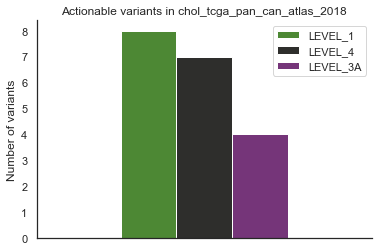

In [82]:
pd.DataFrame(counts_per_level,index=[0]).plot(kind='bar', colors=['#4D8834','#2E2E2C','#753579'])
plt.xticks([])
plt.ylabel('Number of variants')
plt.title('Actionable variants in chol_tcga_pan_can_atlas_2018')
sns.despine()

The current plot could be more useful. See the idea listed here for one example of how to improve it: https://github.com/mskcc/cbsp-hackathon/tree/master/1-ideas/annotate-oncokb-barchart.